In [1]:
## Define constants
WORLDMAP_PATH = "/Users/siddharth/Desktop/worldmap.png"
AIS_DATA_PATH = '~/Desktop/challenge_ais.csv'

In [19]:
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import rescale, resize, downscale_local_mean
from operator import itemgetter
from PIL import Image, ImageDraw
import math
# from mpl_toolkits.basemap import Basemap
# Make Matplotlib plots appear inline
%matplotlib inline

In [3]:
ais_data = pd.read_csv(AIS_DATA_PATH)
ais_data.columns
        

Index([u'﻿FID', u'mmsi', u'imo', u'vessel_name', u'callsign', u'vessel_type',
       u'vessel_type_code', u'vessel_type_cargo', u'vessel_class', u'length',
       u'width', u'flag_country', u'flag_code', u'eta', u'draught', u'segment',
       u'from_longitude', u'from_latitude', u'longitude', u'latitude', u'sog',
       u'cog', u'rot', u'heading', u'nav_status', u'nav_status_code',
       u'source', u'ts_pos_utc', u'ts_static_utc', u'dt_pos_utc',
       u'dt_static_utc', u'vessel_type_main', u'vessel_type_sub'],
      dtype='object')

In [4]:
long = ais_data['longitude'].as_matrix()
lat = ais_data['latitude'].as_matrix()
time = pd.to_datetime(ais_data['dt_pos_utc']).as_matrix()
time = (time - time[0]) / 1000000000
print(time)
last_pt = [lat[-1], long[-1]]
print(last_pt)

[    0  3960  7440 21840 24840 29220 32760 35340 39900]
[34.380099999999999, 125.13630000000001]


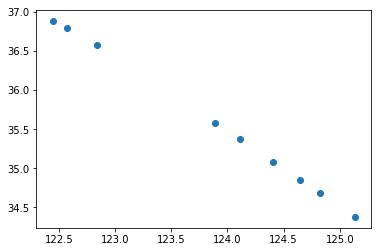

In [5]:
plt.scatter(long, lat)

In [6]:
lat_long = np.vstack((lat, long)).T
dist_traveled = []
vel_at_points = []
for i in range(1, len(lat_long)):
    dist = np.sqrt(np.sum(np.square(lat_long[i] - lat_long[i-1])))
    dist_traveled.append(dist)
    orientation = (lat_long[i] - lat_long[i-1]) / dist
    vel_at_points.append(np.append(orientation, 3600 * dist / (float(time[i] - time[i-1]))))
    
dist_traveled = np.asarray(dist_traveled)
vel_at_points = np.asarray(vel_at_points)
avg_vel = np.average(vel_at_points[:,2])
print(avg_vel)
print(vel_at_points)

0.322319970426
[[-0.54019214  0.84154171  0.13816633]
 [-0.63155059  0.77533467  0.3575764 ]
 [-0.68878922  0.72496166  0.36353647]
 [-0.67744167  0.7355765   0.35090844]
 [-0.69729556  0.71678372  0.34583711]
 [-0.69866101  0.71545286  0.33914753]
 [-0.70090263  0.71325697  0.33883219]
 [-0.69334221  0.72060848  0.3445553 ]]


In [7]:
def get_boundaries(center, width, height):
    left = center[0] - width / 2
    right = center[0] + width / 2
    top = center[1] - height / 2
    bottom = center[1] + height / 2
    return([(left, top), (right, bottom)])

def get_square(delt):
    min_lat = last_pt[0] - avg_vel * delt
    max_lat = last_pt[0] + avg_vel * delt
    min_long = last_pt[1] - avg_vel * delt
    max_long = last_pt[1] + avg_vel * delt
    
    return((min_lat, min_long), (max_lat, max_long))

def get_circle(start_pt, delt, gran, num_top):
    min_lat = start_pt[0] - 2 * avg_vel * delt
    max_lat = start_pt[0] + 2 * avg_vel * delt
    min_long = start_pt[1] - 2 * avg_vel * delt
    max_long = start_pt[1] + 2 * avg_vel * delt
    
    print(min_lat, max_lat)
    print(min_long, max_long)
    
    im = np.zeros(shape=gran)
    
    lats = np.zeros(gran[0])
    longs = np.zeros(gran[1])
    
    cell_width = (max_lat - min_lat) / gran[0]
    cell_height = (max_long - min_long) / gran[1]
    
    for i in range(len(lats)):
        lats[i] = min_lat + (max_lat - min_lat) * (2*i + 1) / (2*len(lats))
    for i in range(len(longs)):
        longs[i] = min_long + (max_long - min_long) * (2*i + 1) / (2*len(longs))
    
    print(lats, longs)
    
    top_regions = []
    
    for i in range(len(lats)):
        for j in range(len(longs)):
            pt_dist = np.sqrt(np.sum(np.square([lats[i] - start_pt[0], longs[j] - start_pt[1]])))
            heat = -np.absolute(pt_dist - avg_vel * delt) / avg_vel
            im[i][j] = heat
            top_regions.append([heat, get_boundaries([lats[i], longs[j]], cell_width, cell_height)])
    
    top_regions = sorted(top_regions, key=itemgetter(0))
    top_regions = top_regions[::-1]
    aoi = [v[1] for v in top_regions[:num_top]]
    print(aoi)
    
    return im, top_regions[:num_top]
    

In [8]:
get_square(10)

((31.156900295737941, 121.91310029573795),
 (37.603299704262056, 128.35949970426205))

In [9]:
im, top = get_circle(last_pt, 10, (10, 10), 10)

(27.933700591475887, 40.826499408524114)
(118.68990059147589, 131.58269940852412)
(array([ 28.57834053,  29.86762041,  31.1569003 ,  32.44618018,
        33.73546006,  35.02473994,  36.31401982,  37.6032997 ,
        38.89257959,  40.18185947]), array([ 119.33454053,  120.62382041,  121.9131003 ,  123.20238018,
        124.49166006,  125.78093994,  127.07021982,  128.3594997 ,
        129.64877959,  130.93805947]))
[[(30.512260354885534, 125.13630000000001), (31.801540236590355, 126.42557988170483)], [(30.512260354885534, 123.84702011829518), (31.801540236590355, 125.13630000000001)], [(33.090820118295177, 121.26846035488553), (34.380100000000006, 122.55774023659036)], [(36.958659763409642, 125.13630000000001), (38.247939645114471, 126.42557988170483)], [(36.958659763409642, 123.84702011829518), (38.247939645114471, 125.13630000000001)], [(34.380099999999999, 121.26846035488553), (35.669379881704828, 122.55774023659036)], [(33.090820118295177, 127.71485976340966), (34.380100000000006, 

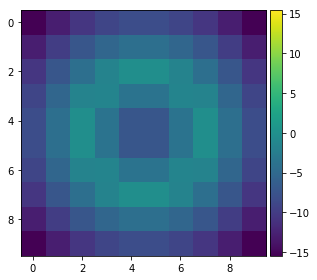

In [10]:
skimage.io.imshow(im, cmap=plt.cm.viridis)
plt.show()

In [29]:
CLIP_LOW = -20.0
CLIP_HIGH = 20.0

def dotproduct(v1, v2):
  return sum((a*b) for a, b in zip(v1, v2))

def length(v):
  return math.sqrt(dotproduct(v, v))

def angle(v1, v2):
  return math.acos(dotproduct(v1, v2) / (length(v1) * length(v2)))


def get_heat_trajectory(start_pt, ranges, vel, traj, delt, gran, num_top):
#     min_lat = start_pt[0] - 2 * vel * delt
#     max_lat = start_pt[0] + 2 * vel * delt
#     min_long = start_pt[1] - 2 * vel * delt
#     max_long = start_pt[1] + 2 * vel * delt
    
    min_lat = ranges[0]
    max_lat = ranges[1]
    min_long = ranges[2]
    max_long = ranges[3]
    
    best_pt = vel * delt * traj + start_pt
    
    print(best_pt)
    
    im = np.zeros(shape=gran)
    
    lats = np.zeros(gran[0])
    longs = np.zeros(gran[1])
    
    cell_width = (max_lat - min_lat) / gran[0]
    cell_height = (max_long - min_long) / gran[1]
    print(cell_width, cell_height)
    
    for i in range(len(lats)):
        lats[i] = min_lat + (max_lat - min_lat) * (2*i + 1) / (2*len(lats))
    for i in range(len(longs)):
        longs[i] = min_long + (max_long - min_long) * (2*i + 1) / (2*len(longs))
    
#     print(lats, longs)
    
    # Get current contribution:
    curr_vectors = generate_currents_ex(ranges, gran)
    nsteps = int(vel * delt / np.sqrt(cell_width*cell_width + cell_height*cell_height))
    start_cell = [int(np.floor((start_pt[0] - ranges[0]) / cell_width)), int(np.floor((start_pt[1] - ranges[2]) / cell_height))]
    while(is_land(lats[start_cell[0]], longs[start_cell[1]])):
        start_cell[0] = start_cell[0] - 1
    print(start_cell, nsteps)
    curr_contrib = propagate_field(curr_vectors, nsteps, start_cell, gran) 

    
    top_regions = []
    
    for i in range(len(lats)):
        for j in range(len(longs)):
            if is_land(lats[i], longs[j]):
                im[i][j] = CLIP_HIGH
            else:
                pt_dist = np.sqrt(np.sum(np.square([lats[i] - start_pt[0], longs[j] - start_pt[1]])))
                heat = -np.absolute(pt_dist - vel * delt) * (1 - np.cos(angle(traj, [lats[i] - start_pt[0], longs[j] - start_pt[1]]))) / vel
                bestpt_dist = np.sqrt(np.sum(np.square([lats[i] - best_pt[0], longs[j] - best_pt[1]])))
                heat = heat - 2 * bestpt_dist / vel
                heat = heat + curr_contrib[i][j]
                if heat < CLIP_LOW:
                    heat = CLIP_LOW
                im[i][j] = heat
                top_regions.append([heat, get_boundaries([lats[i], longs[j]], cell_width, cell_height)])
    

    top_regions = sorted(top_regions, key=itemgetter(0))
    top_regions = top_regions[::-1]
    aoi = [v[1] for v in top_regions[:num_top]]
    print(aoi)
    
    return im, top_regions[:num_top]
    

In [12]:
def generate_currents_ex(ranges, gran):
    curr_vectors = np.zeros(shape=(gran[0], gran[1], 2))

    lats = np.zeros(gran[0])
    longs = np.zeros(gran[1])
    
    for i in range(len(lats)):
        lats[i] = ranges[0] + (ranges[1] - ranges[0]) * (2*i + 1) / (2*len(lats))
    for i in range(len(longs)):
        longs[i] = ranges[2] + (ranges[3] - ranges[2]) * (2*i + 1) / (2*len(longs))

    for i in range(len(lats)):
        for j in range(len(longs)):
            if is_land(lats[i], longs[j]):
                curr_vectors[i][j] = [0.0, 0.0]
            else:
                curr_vectors[i][j][0] = np.sin(i * 7 / gran[0]) + 1.0
                curr_vectors[i][j][1] = np.cos(j * 5 / gran[1]) + 1.0
                
    return curr_vectors

In [13]:
def is_land(lat, long):
    pixel_long = int((long + 180.0) * 10800.0 / 360.0)
    pixel_lat = int((90.0 - lat) * 5400.0 / 180.0)
#     worldmask2 = worldmask[pixel_lat-200:pixel_lat+200, pixel_long-200:pixel_long+400]
#     worldmask2[pixel_lat-500:pixel_lat+500, pixel_long-500:pixel_long+500] = 0
#     img = Image.fromarray(np.uint8(worldmask2))
#     img.show()
    if worldmask[pixel_lat][pixel_long] == 0:
        return False
    else:
        return True

In [14]:
img = Image.open(WORLDMAP_PATH)
worldmask = np.asarray(list(img.getdata())).reshape((5400, 10800))

In [15]:
def propagate_field(curr_field, nsteps, start_cell, gran):
    prob_values = np.zeros(shape=gran)
    step_labels = np.zeros(shape=gran)
    prob_values[start_cell[0], start_cell[1]] = nsteps
    step_labels[start_cell[0], start_cell[1]] = 1
    for t in range(1, 2*nsteps):
#         print(t)
        for i in range(gran[0]):
            for j in range(gran[1]):
                pv = prob_values[i][j]
#                 if pv != 0.0:
#                     print(pv)
#                     print(curr_field[i][j])
                if step_labels[i][j] == t and (curr_field[i][j][0] != 0.0 or curr_field[i][j][1] != 0.0):
                    idir = curr_field[i][j][0]
                    jdir = curr_field[i][j][1]
                    sumij = np.absolute(idir) + np.absolute(jdir)
#                     print(idir, jdir)
                    if idir < 0 and (step_labels[i-1][j] == 0 or step_labels[i-1][j] == t + 1):
                        prob_values[i-1][j] += pv * np.absolute(idir) / sumij
                        step_labels[i-1][j] = t + 1
                    elif idir >= 0 and (step_labels[i+1][j] == 0 or step_labels[i+1][j] == t + 1):
                        prob_values[i+1][j] += pv * np.absolute(idir) / sumij
                        step_labels[i+1][j] = t + 1
                    if jdir < 0 and (step_labels[i][j-1] == 0 or step_labels[i][j-1] == t + 1):
                        prob_values[i][j-1] += pv * np.absolute(jdir) / sumij
                        step_labels[i][j-1] = t + 1
                    elif jdir >= 0 and (step_labels[i][j+1] == 0 or step_labels[i][j+1] == t + 1):
                        prob_values[i][j+1] += pv * np.absolute(jdir) / sumij
                        step_labels[i][j+1] = t + 1
    
    for i in range(gran[0]):
        for j in range(gran[1]):
            if step_labels[i][j] < 0.7 * nsteps or step_labels[i][j] > 1.3 * nsteps:
                prob_values[i][j] = 0.0

    return prob_values * nsteps * 5

                    

In [32]:
min_lat = last_pt[0] - 5
max_lat = last_pt[0] + 6
min_long = last_pt[1] - 5
max_long = last_pt[1] + 8
ranges = [min_lat, max_lat, min_long, max_long]

gran = (110, 130)
hrs_ahead = 2
im, top = get_heat_trajectory(last_pt, ranges, vel_at_points[-1][2], vel_at_points[-1][:2], hrs_ahead, gran, 10)
rotated = im[::-1]

[  33.90231053  125.63287895]
(0.10000000000000001, 0.10000000000000001)
([45, 50], 4)
[[(33.880099999999999, 125.33630000000001), (33.980099999999993, 125.4363)], [(33.9801, 125.33630000000001), (34.080099999999995, 125.4363)], [(33.880099999999999, 125.4363), (33.980099999999993, 125.5363)], [(33.880099999999999, 125.53630000000001), (33.980099999999993, 125.63630000000001)], [(33.880099999999999, 125.63630000000001), (33.980099999999993, 125.7363)], [(33.780100000000004, 125.53630000000001), (33.880099999999999, 125.63630000000001)], [(33.780100000000004, 125.63630000000001), (33.880099999999999, 125.7363)], [(33.880099999999999, 125.73630000000001), (33.980099999999993, 125.83630000000001)], [(33.780100000000004, 125.4363), (33.880099999999999, 125.5363)], [(33.780100000000004, 125.73630000000001), (33.880099999999999, 125.83630000000001)]]


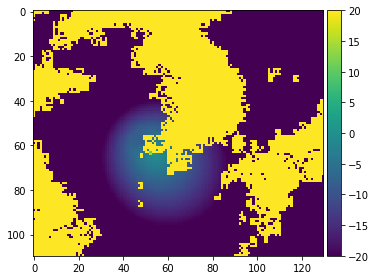

In [33]:
skimage.io.imshow(rotated, cmap=plt.cm.viridis)
plt.show()

In [18]:
skimage.io.imshow(image_resized, cmap=plt.cm.viridis)
plt.show()

NameError: name 'image_resized' is not defined

In [ ]:
def wrapper_get_boxes(last_pt, vel, traj, delt, num_boxes):
    pass

In [ ]:
is_land(35.4, 127)

In [ ]:
curr_vectors = generate_currents_ex(ranges, (50, 50))

In [ ]:
skimage.io.imshow(curr_vectors[:,:,0], cmap=plt.cm.viridis)

In [ ]:
skimage.io.imshow(curr_vectors[:,:,1], cmap=plt.cm.viridis)

In [ ]:
prob_values = propagate_field(curr_vectors, 11, [24, 25], (50, 50))

In [ ]:
skimage.io.imshow(prob_values, cmap=plt.cm.viridis)

In [ ]:
lats = np.zeros(gran[0])
longs = np.zeros(gran[1])

for i in range(len(lats)):
    lats[i] = ranges[0] + (ranges[1] - ranges[0]) * (2*i + 1) / (2*len(lats))
for i in range(len(longs)):
    longs[i] = ranges[2] + (ranges[3] - ranges[2]) * (2*i + 1) / (2*len(longs))

In [ ]:
for half_hr in range(1, 5):
    hrs_ahead = half_hr * 0.5
    im, top = get_heat_trajectory(last_pt, ranges, avg_vel, vel_at_points[-1][:2], hrs_ahead, gran, 10)
    jsLines = []
    for i in range(len(lats)):
        lat = lats[i]
        for j in range(len(longs)):
            if not is_land(lats[i], longs[j]) and im[i][j] > CLIP_LOW:
                lng = longs[j]            
                scaledImVal = (im[i][j] - CLIP_LOW) / float(CLIP_HIGH - CLIP_LOW)
                jsLines.append("[%s, %s, %s]"%(lat, lng, scaledImVal))
    print("var grid%s = [\t"%half_hr)
    print(",\n\t").join(jsLines)
    print("]")

                    

In [ ]:
print(np.mean(prob_values))